In [ ]:
!pip install ipywidgets
!pip install fpdf

In [ ]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import io
from fpdf import FPDF
from PIL import Image
from google.colab import files


# Configuración general
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import io
from fpdf import FPDF
from PIL import Image
from google.colab import files


# Configuración general
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

def analizar_df(df, nombre="Archivo"):
    df = df.dropna(axis=1, how='all')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.drop_duplicates(subset='Id')
    df["Sexo"] = df["Sexo"].fillna("No definido")
    # Filter out rows where Sexo is 'No definido'
    df = df[df['Sexo'] != 'No definido'].copy()
    df["Edad (en meses)"] = pd.to_numeric(df["Edad (en meses)"], errors='coerce')
    df["Fecha de nacimiento"] = pd.to_datetime(df["Fecha de nacimiento"], errors='coerce')
    df["Edad (años)"] = df["Edad (en meses)"] // 12

    print(f"\n🔍 Análisis de {nombre}")
    print("Tamaño:", df.shape)
    print("Distribución por sexo:")
    print(df["Sexo"].value_counts())

    plt.figure()
    sns.countplot(data=df, x="Sexo")
    plt.title("Distribución por sexo")
    plt.show()

    plt.figure()
    sns.histplot(df["Edad (años)"].dropna(), bins=15, kde=True)
    plt.title("Distribución de Edad")
    plt.show()

    nivel_cols = [col for col in df.columns if "Nivel de" in col and "formato" in col]
    if nivel_cols:
        df[nivel_cols].mean().sort_values().plot(kind='barh')
        plt.title("Promedio de Indicadores Visuales")
        plt.tight_layout()
        plt.show()

        if "Nivel de estrabismo con formato" in df.columns:
            sns.boxplot(data=df, x="Sexo", y="Nivel de estrabismo con formato")
            plt.title("Estrabismo por Sexo")
            plt.show()

        corr = df[nivel_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title("Correlación entre indicadores visuales")
        plt.show()

In [ ]:
def generar_pdf_reporte(df, nombre_pdf="reporte_visual.pdf"):
    df = df.dropna(axis=1, how='all')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.drop_duplicates(subset='Id')
    df["Sexo"] = df["Sexo"].fillna("No definido")
    # Filter out rows where Sexo is 'No definido'
    df = df[df['Sexo'] != 'No definido'].copy()
    df["Edad (en meses)"] = pd.to_numeric(df["Edad (en meses)"], errors='coerce')
    df["Fecha de nacimiento"] = pd.to_datetime(df["Fecha de nacimiento"], errors='coerce')
    df["Edad (años)"] = df["Edad (en meses)"] // 12
    nivel_cols = [col for col in df.columns if "Nivel de" in col and "formato" in col]

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", "B", 16)
    pdf.cell(200, 10, "Reporte de Tamizaje Visual", ln=1, align="C")

    pdf.set_font("Arial", size=12)
    pdf.multi_cell(0, 10, f"""
- Total registros: {df.shape[0]}
- Total columnas: {df.shape[1]}
- Distribución por sexo:
{df["Sexo"].value_counts().to_string()}
""")

    def guardar_grafica(fig, nombre):
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        img = Image.open(buf)
        img.save(f"{nombre}.png")
        pdf.add_page()
        pdf.image(f"{nombre}.png", x=10, y=20, w=180)
        buf.close()

    fig1, ax1 = plt.subplots()
    sns.countplot(data=df, x="Sexo", ax=ax1)
    ax1.set_title("Distribución por Sexo")
    guardar_grafica(fig1, "sexo")
    plt.close(fig1)

    fig2, ax2 = plt.subplots()
    sns.histplot(df["Edad (años)"].dropna(), bins=15, kde=True, ax=ax2)
    ax2.set_title("Distribución de Edad (años)")
    guardar_grafica(fig2, "edad")
    plt.close(fig2)

    if nivel_cols:
        fig3, ax3 = plt.subplots()
        df[nivel_cols].mean().sort_values().plot(kind='barh', ax=ax3)
        ax3.set_title("Promedio de Indicadores Visuales")
        guardar_grafica(fig3, "niveles")
        plt.close(fig3)

        if "Nivel de estrabismo con formato" in df.columns:
            fig4, ax4 = plt.subplots()
            sns.boxplot(data=df, x="Sexo", y="Nivel de estrabismo con formato", ax=ax4)
            ax4.set_title("Estrabismo por Sexo")
            guardar_grafica(fig4, "estrabismo")
            plt.close(fig4)

        fig5, ax5 = plt.subplots()
        sns.heatmap(df[nivel_cols].corr(), annot=True, cmap='coolwarm', ax=ax5)
        ax5.set_title("Correlación entre Indicadores Visuales")
        guardar_grafica(fig5, "correlacion")
        plt.close(fig5)
    # Boxplot edad por sexo
    fig6, ax6 = plt.subplots()
    sns.boxplot(data=df, x="Sexo", y="Edad (años)", ax=ax6)
    ax6.set_title("Distribución de Edad por Sexo")
    guardar_grafica(fig6, "edad_sexo")
    plt.close(fig6)

    # Promedio indicadores por sexo
    fig7, ax7 = plt.subplots()
    df.groupby("Sexo")[nivel_cols].mean().T.plot(kind='barh', ax=ax7)
    ax7.set_title("Indicadores visuales promedios por Sexo")
    plt.tight_layout()
    guardar_grafica(fig7, "promedios_sexo")
    plt.close(fig7)

    # Mapa de calor edad-indicadores
    df["Grupo Edad"] = pd.cut(df["Edad (años)"], bins=[0, 3, 6, 9, 12, 15, 18], labels=["0-3", "4-6", "7-9", "10-12", "13-15", "16-18"])
    fig8, ax8 = plt.subplots()
    sns.heatmap(df.groupby("Grupo Edad")[nivel_cols].mean(), annot=True, cmap="YlGnBu", ax=ax8)
    ax8.set_title("Indicadores Visuales por Grupo de Edad")
    guardar_grafica(fig8, "heatmap_edad")
    plt.close(fig8)

    # Dispersión astigmatismo vs estrabismo
    if "Nivel de astigmatismo con formato" in df.columns and "Nivel de estrabismo con formato" in df.columns:
        fig9, ax9 = plt.subplots()
        sns.scatterplot(data=df, x="Nivel de astigmatismo con formato", y="Nivel de estrabismo con formato", hue="Sexo", ax=ax9)
        ax9.set_title("Astigmatismo vs Estrabismo")
        guardar_grafica(fig9, "astig_estrab")
        plt.close(fig9)

    pdf.output(nombre_pdf)
    print(f"✅ Reporte generado: {nombre_pdf}")
    # Remove automatic download

In [ ]:
def analizar_un_archivo(upload_value):
    clear_output(wait=True)
    display(menu_selector)
    nombre = list(upload_value.keys())[0]
    archivo = upload_value[nombre]
    df = pd.read_csv(io.BytesIO(archivo['content']))
    analizar_df(df, nombre)
    pdf_filename = f"reporte_{nombre.replace('.csv', '')}.pdf"
    generar_pdf_reporte(df, pdf_filename)
    descargar_reporte_pdf(pdf_filename) # Trigger download after generation


def analizar_lote(upload_dict):
    clear_output(wait=True)
    display(menu_selector)
    for nombre, archivo in upload_dict.items():
        print("\n" + "-"*60)
        df = pd.read_csv(io.BytesIO(archivo['content']))
        analizar_df(df, nombre)
        print("-"*60)

Dropdown(description='Modo:', index=3, options=('Selecciona una opción', '📄 Analizar un archivo', '📂 Analizar …

Fusionando archivos...

🔍 Análisis de Archivo
Tamaño: (833, 115)
Distribución por sexo:
Sexo
M    456
H    377
Name: count, dtype: int64


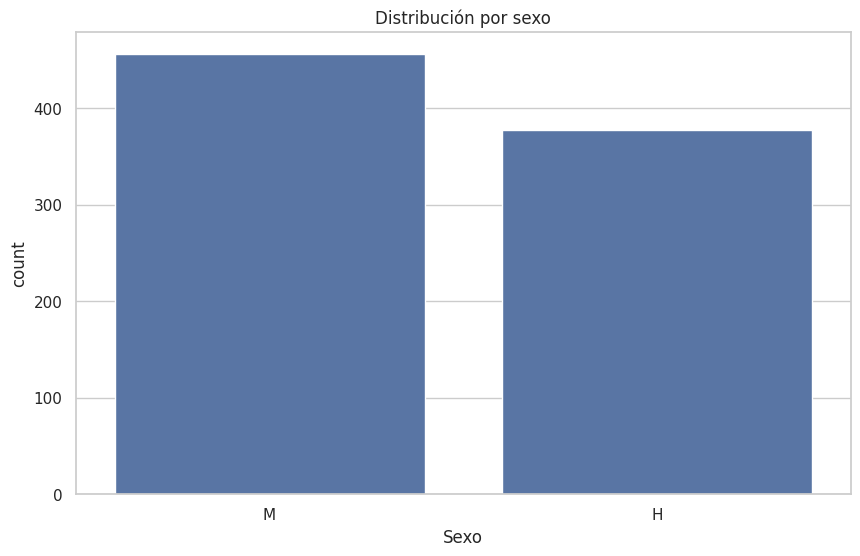

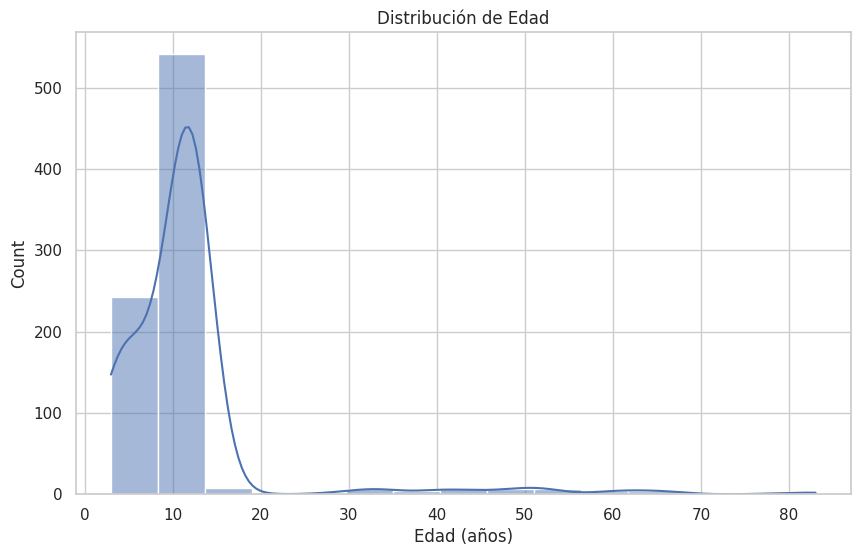

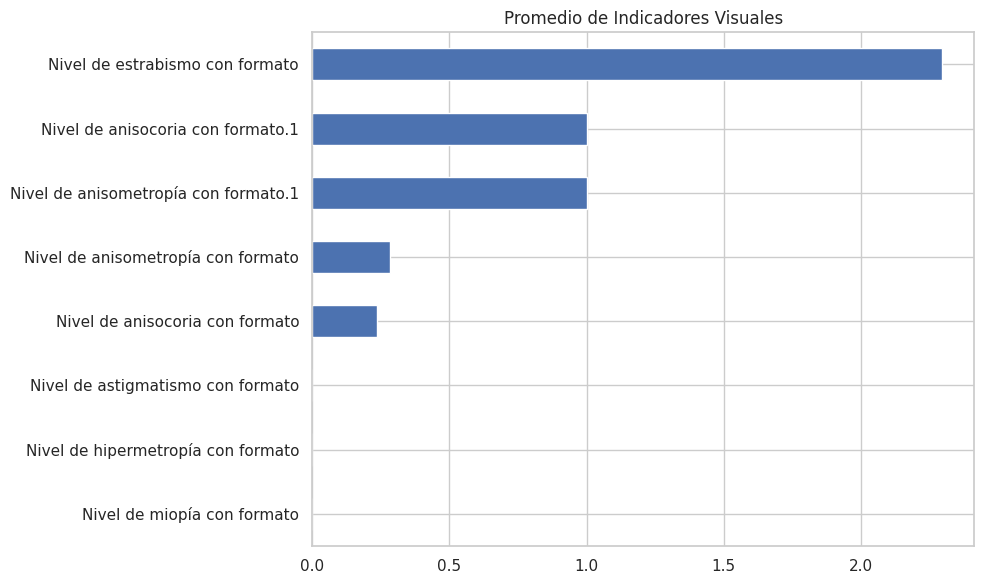

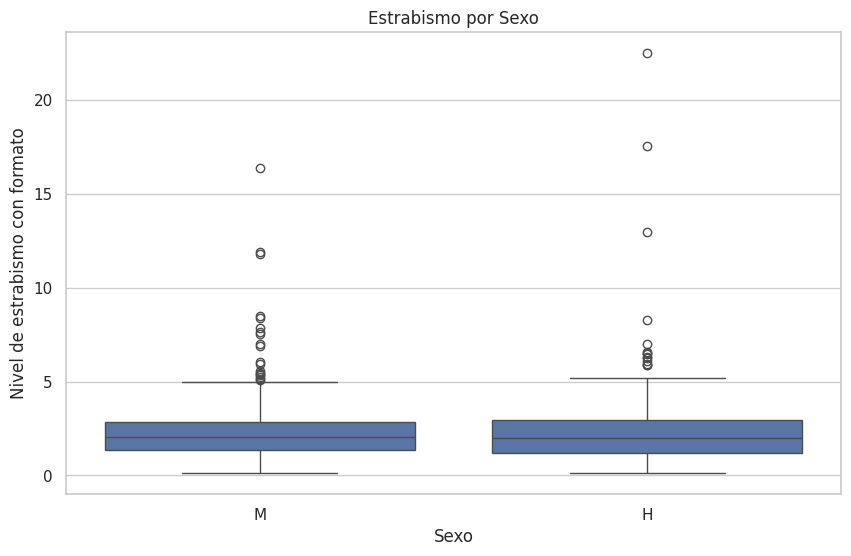

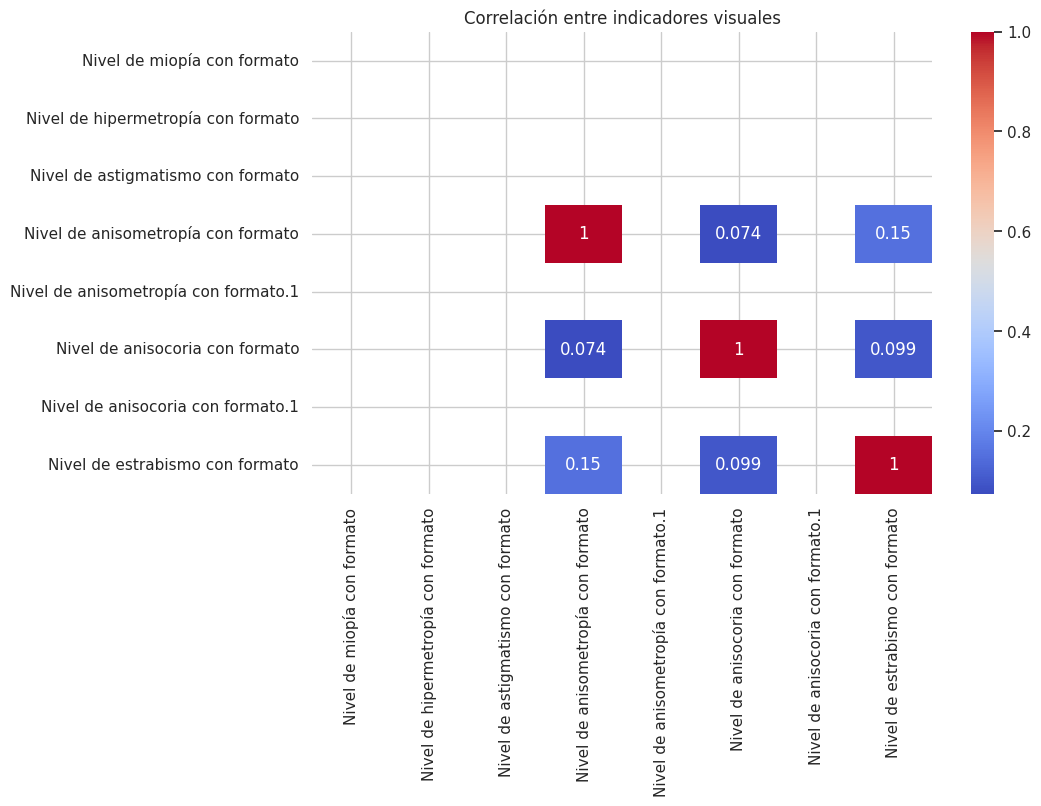

/tmp/ipython-input-51-610507062.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.heatmap(df.groupby("Grupo Edad")[nivel_cols].mean(), annot=True, cmap="YlGnBu", ax=ax8)


✅ Reporte generado: reporte_fusionado.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Menú de selección
opciones = ["Selecciona una opción", "📄 Analizar un archivo", "📂 Analizar lote de archivos", "🔗 Fusionar y analizar archivos"]
menu_selector = widgets.Dropdown(options=opciones, description="Modo:")
upload_widget = widgets.FileUpload(accept='.csv', multiple=False)
upload_lote = widgets.FileUpload(accept='.csv', multiple=True)
upload_fusion = widgets.FileUpload(accept='.csv', multiple=True)

def on_upload_uno(change):
    if upload_widget.value:
        analizar_un_archivo(upload_widget.value)

def on_upload_lote(change):
    if upload_lote.value:
        analizar_lote(upload_lote.value)

def on_upload_fusion(change):
    if upload_fusion.value:
        analizar_archivos_fusionados(upload_fusion.value)


def on_menu_change(change):
    clear_output(wait=True)
    display(menu_selector)

    if change["new"] == "📄 Analizar un archivo":
        print("📄 Sube un archivo CSV:")
        display(upload_widget)
    elif change["new"] == "📂 Analizar lote de archivos":
        print("📂 Sube varios archivos CSV para analizarlos uno por uno:")
        display(upload_lote)
    elif change["new"] == "🔗 Fusionar y analizar archivos":
        print("🔗 Sube varios archivos CSV para fusionarlos:")
        display(upload_fusion)

upload_widget.observe(on_upload_uno, names='value')
upload_lote.observe(on_upload_lote, names='value')
upload_fusion.observe(on_upload_fusion, names='value')


# Mostrar el menú inicial
display(menu_selector)
menu_selector.observe(on_menu_change, names="value")

In [ ]:
def analizar_archivos_fusionados(upload_dict):
    clear_output(wait=True)
    display(menu_selector)
    print("Fusionando archivos...")

    lista_df = []
    for nombre, archivo in upload_dict.items():
        df = pd.read_csv(io.BytesIO(archivo['content']))
        lista_df.append(df)

    df_fusionado = pd.concat(lista_df, ignore_index=True)
    pdf_filename = "reporte_fusionado.pdf"
    analizar_df(df_fusionado)
    generar_pdf_reporte(df_fusionado, pdf_filename)
    descargar_reporte_pdf(pdf_filename) # Trigger download after generation

In [ ]:
def on_upload_uno(change):
    if upload_widget.value:
        analizar_un_archivo(upload_widget.value)

def on_upload_lote(change):
    if upload_lote.value:
        analizar_lote(upload_lote.value)
def on_upload_fusion(change):
    if upload_fusion.value:
        analizar_archivos_fusionados(upload_fusion.value)






In [ ]:
def descargar_reporte_pdf(nombre_pdf=None):
    if nombre_pdf:
        try:
            files.download(nombre_pdf)
        except FileNotFoundError:
            print(f"El archivo {nombre_pdf} no se ha generado aún. Por favor, analiza un archivo primero.")
    else:
        print("No se ha especificado un nombre de archivo para descargar. Por favor, analiza un archivo primero.")

# We will update the download button's behavior in the on_upload functions
download_button = widgets.Button(description="Descargar Reporte PDF")
# Remove the old on_click handler as we will handle download in the analysis functions
# download_button.on_click(lambda b: descargar_reporte_pdf())
display(HTML("<h3>📤 Generar y descargar reporte en PDF</h3>"))
display(download_button)

Button(description='Descargar Reporte PDF', style=ButtonStyle())

In [ ]:
def on_upload_uno(change):
    if upload_widget.value:
        analizar_un_archivo(upload_widget.value)

def on_upload_lote(change):
    if upload_lote.value:
        analizar_lote(upload_lote.value)
def on_upload_fusion(change):
    if upload_fusion.value:
        analizar_archivos_fusionados(upload_fusion.value)